# Para el ejercicio se busca realizar las siguientes tareas:

##Integrantes:
Christian Zhirzhan, Evelyn Pintado

1.   Visualizar los datos registrados en la pandemia del Covid-19
2.   Desarrollar modelos de predicccion para los casos confirmados (SVM, Regresion Linear, Red Bayessiana)

Para esto se usa 2 datasets, "covid_19_data.csv" y "time_series_covid_19_confirmed.csv", para visualizacion y entrenamiento respectivamente. El uso del dataset "time_series_covid_19_confirmed.csv" se debe a su disponibilidad de datos para distintas fechas lo que nos ayuda en la prediccion



**Preprocesamiento**


In [ ]:
#importamos las librerias necesarias
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from plotly.subplots import make_subplots
from folium import plugins
from tqdm.notebook import tqdm as tqdm

import math, time 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors
import random
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline
import statsmodels as sm
import folium as fl
import plotly.offline as py
import plotly.express as px
import cufflinks as cf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
import folium 

import warnings
warnings.filterwarnings('ignore')

print('####IMPORTADAS####')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



####IMPORTADAS####


CARGA DE DATASETS


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving time_series_covid_19_confirmed.csv to time_series_covid_19_confirmed.csv


In [ ]:
covid_df = pd.read_csv('covid_19_data.csv')
covid_df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
confirmed_df = pd.read_csv('time_series_covid_19_confirmed.csv')
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192,2269,2330,2402,2466,2535,2580,2662,2752,2819,2893,2964,3038,3106
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404,16879,17348
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140,142,148,155,166,172,176,183,186,189,197,212,212,259,267,276,284,291,315,328,346,346,346,386,386


In [ ]:
columns = confirmed_df.keys()
confirmed = confirmed_df.loc[:, columns[4]:columns[-1]]

dates = confirmed.keys()
world_cases = []


for i in dates:
    confirmed_sum = confirmed[i].sum()
    world_cases.append(confirmed_sum)
    

In [ ]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)


**Limpieza de Datos y Estandarización**


1. En el dataset completo, procedemos a remplazar los campos vacios con valores de 0

In [ ]:
cleaned_data= covid_df
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
cleaned_data['Active'] = cleaned_data['Confirmed'] - cleaned_data['Deaths'] - cleaned_data['Recovered']

# filling missing values 
cleaned_data[['Province/State']] = cleaned_data[['Province/State']].fillna('')
cleaned_data[cases] = cleaned_data[cases].fillna(0)

cleaned_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Active
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,1.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,14.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,6.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,1.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,0.0


In [ ]:
temp = cleaned_data.groupby('Last Update')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Last Update", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Estado', value_name='Casos')
fig = px.area(temp, x="Last Update", y="Casos", color='Estado',
             title='Representacion de los datos hasta Julio', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.show()




***Predicción SVM***


Uso del dataset "time_series_covid_19_confirmed.csv"


In [ ]:
days_in_future = 15
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]

In [ ]:
confirmed_df = cleaned_data
deaths_df = cleaned_data
recoveries_df = cleaned_data


In [ ]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [ ]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.15, shuffle=False) 

In [ ]:
from time import time


kernel = ['poly', 'sigmoid']
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.1, 1]

svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
start_time = time()
svm_search.fit(X_train_confirmed, y_train_confirmed)
elapsed_time = time() - start_time
tiempoSVR=elapsed_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed_time)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.0min


Tiempo de ejecucion: 242.7612886429 segundos.


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.0min finished


In [ ]:
svm_search.best_params_

{'C': 1, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}

In [ ]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 1137520.7799807657
MSE: 1370444278854.5466


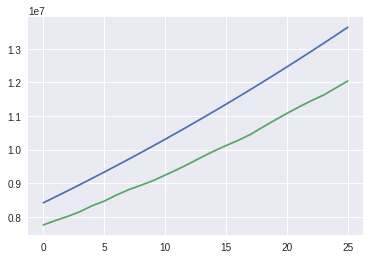

In [ ]:
# checking against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

**Regresión**


In [ ]:
linear_model = LinearRegression(normalize=True, fit_intercept=True)
start_time = time()
linear_model.fit(X_train_confirmed, y_train_confirmed)
elapsed_time = time() - start_time
tiempoRegresion=elapsed_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed_time)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

Tiempo de ejecucion: 0.0284647942 segundos.
MAE: 3161344.482956599
MSE: 10795765186053.848


**Lineal BayesianRidge**

In [ ]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)

start_time = time()
bayesian_search.fit(X_train_confirmed, y_train_confirmed)
elapsed_time = time() - start_time
tiempoBayesian=elapsed_time
print("Tiempo de ejecucion: %.10f segundos." % elapsed_time)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Tiempo de ejecucion: 0.4130301476 segundos.


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished


In [ ]:
bayesian_search.best_params_

{'alpha_1': 0.0001,
 'alpha_2': 0.0001,
 'lambda_1': 1e-07,
 'lambda_2': 1e-05,
 'tol': 0.01}

In [ ]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))



MAE: 3166160.1685809814
MSE: 10826999482846.498


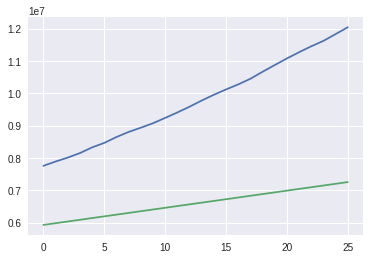

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)

***Repesentacion de comportamiento de cada modelo ***

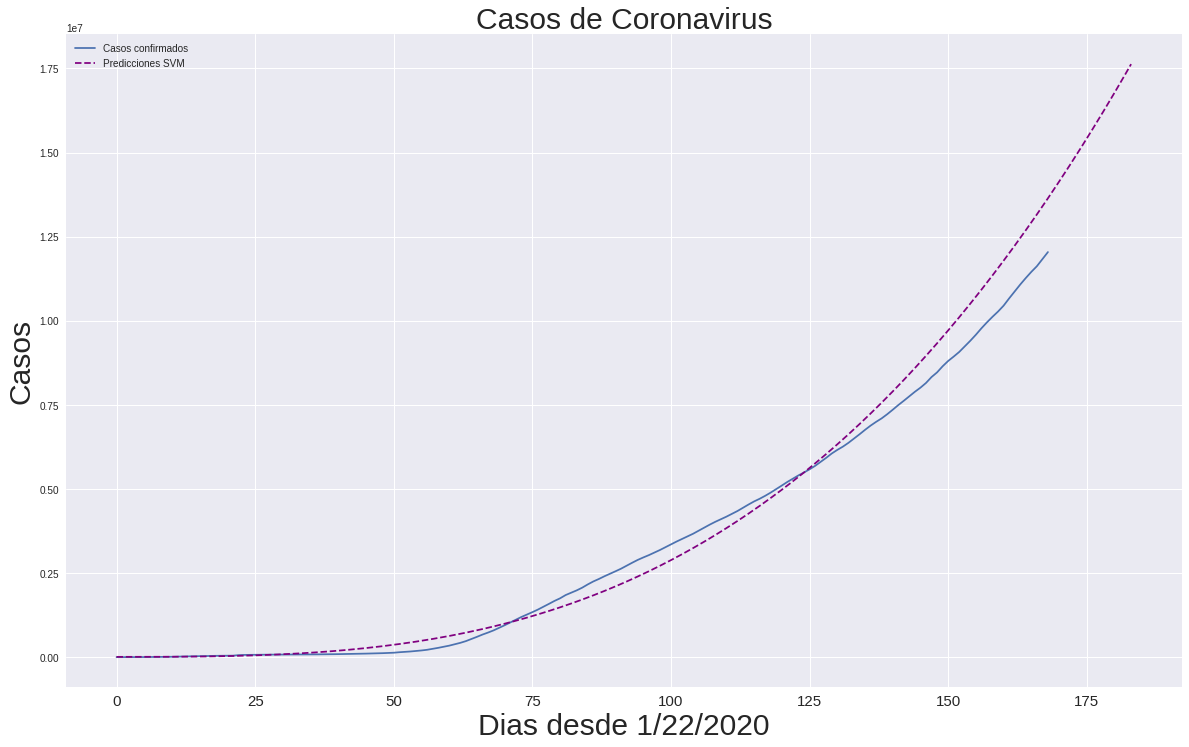

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('Casos de Coronavirus', size=30)
plt.xlabel('Dias desde 1/22/2020', size=30)
plt.ylabel('Casos', size=30)
plt.legend(['Casos confirmados', 'Predicciones SVM'])
plt.xticks(size=15)
plt.show()

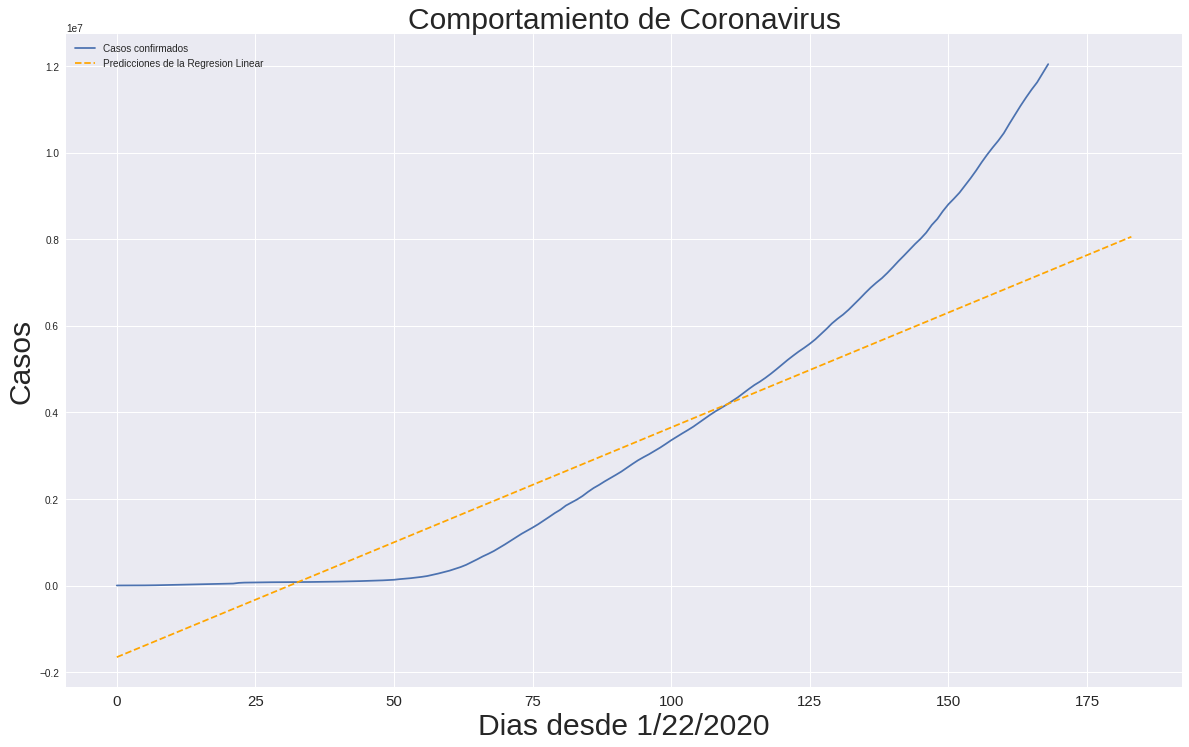

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('Comportamiento de Coronavirus', size=30)
plt.xlabel('Dias desde 1/22/2020', size=30)
plt.ylabel('Casos', size=30)
plt.legend(['Casos confirmados', 'Predicciones de la Regresion Linear'])
plt.xticks(size=15)
plt.show()


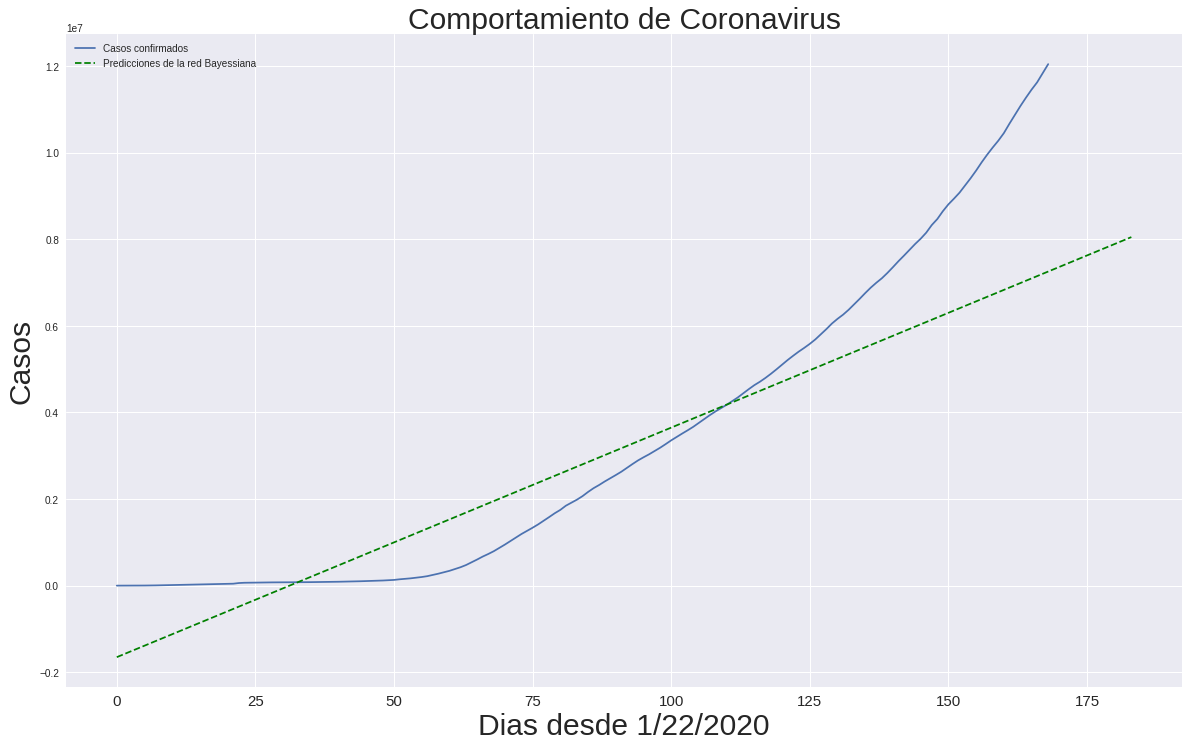

In [ ]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('Comportamiento de Coronavirus', size=30)
plt.xlabel('Dias desde 1/22/2020', size=30)
plt.ylabel('Casos', size=30)
plt.legend(['Casos confirmados', 'Predicciones de la red Bayessiana'])
plt.xticks(size=15)
plt.show()

**Mapas de Calor**

In [ ]:
formated_gdf = cleaned_data.groupby(['Last Update', 'Country/Region'])['Confirmed', 'Deaths', 'Active', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Last Update'] = pd.to_datetime(formated_gdf['Last Update'])
formated_gdf['Last Update'] = formated_gdf['Last Update'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Active'].pow(0.3)
formated_gdf['size'].fillna(formated_gdf['size'].mean(),inplace=True)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Active", size='size', hover_name="Country/Region", 
                     range_color= [0, 1000], 
                     projection="natural earth", animation_frame="Last Update", 
                     title='COVID-19: Active Cases Over Time', color_continuous_scale="portland")
fig.update(layout_coloraxis_showscale=False)
fig.show()